In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn as sk
import scipy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

Question 4.1

In [2]:
class_1 = np.array([[2,2],[4,4],[4,0]])
class_2 = np.array([[0,0],[2,0],[0,2]])
x_train = np.concatenate((class_1,class_2),axis=0)
y_train = np.array([1,1,1,-1,-1,-1])

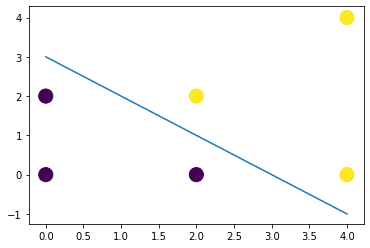

In [3]:
plt.scatter(x_train[:,0],x_train[:,1],c=y_train,s = 200)
#Introspected Optimal weight Vector
w1=1
w2=1
b=-3
decision_func = lambda x: - (w1/w2) * x - b/w2
xvals = np.linspace(0, 4, 10)
plt.plot(xvals, decision_func(xvals))
plt.show()

Yellow = +1 class
Black = -1 class

Hyperplane = x1 + x2 - 3

In [4]:
#Calculating Margin
gammas = (y_train.reshape(-1,1))*(w1*x_train[:,0] + w2*x_train[:,1] + b).reshape(-1,1)
gamma = gammas.min()
norm = math.sqrt(w1**2 + w2**2)
margin = 2*gamma/norm
print("Margin is " + str(margin))


Margin is 1.414213562373095


Question 4.1.1b

Support vectors are points in the training data which lie on the margin on either side of the plane. They are basically points which lie closest to the hypothesis plane for both the classes. In the above case they are the points in the -1 class and the +1 class which lie closest to the plane defined by w1x1+w2x2+b
They are called support vectors because they are used in calculating the hyper plane in SVMs. They are responsible for seperating the classes and support the hyper plane, hence the name

Question 4.2

Spam Data Preprocessing

In [5]:
filePath = "spam_train.txt"
file=open(filePath)
emailList = file.read().splitlines()
filePath2 = "spam_test.txt"
file2=open(filePath2)
testList = file2.read().splitlines()

In [6]:
train_data=emailList[0:4000]
validation_data=emailList[4000:]

In [7]:
new_email_train=[]
spam_value_train=[]
for email in train_data:
    spam_value_train.append((int)(email[0]))
    new_email_train.append(email[2:])
new_email_validate=[]
spam_value_validate=[]
for email in validation_data:
    spam_value_validate.append((int)(email[0]))
    new_email_validate.append(email[2:])
for i in range(0,len(spam_value_train)):
    if(spam_value_train[i]==0):
        spam_value_train[i]=-1
for i in range(0,len(spam_value_validate)):
    if(spam_value_validate[i]==0):
        spam_value_validate[i]=-1
new_email_test=[]
spam_value_test=[]
for email in testList:
    spam_value_test.append((int)(email[0]))
    new_email_test.append(email[2:])

In [8]:
count_vect = CountVectorizer()
email_train_counts = count_vect.fit_transform(new_email_train)
email_train_counts_validate = count_vect.transform(new_email_validate)
email_train_counts_test = count_vect.transform(new_email_test)

freq={}
cx = scipy.sparse.coo_matrix(email_train_counts)
cxv = scipy.sparse.coo_matrix(email_train_counts_validate)
cxt = scipy.sparse.coo_matrix(email_train_counts_test)
for i,j in zip(cx.row, cx.col):
    if(j in freq.keys()):
        freq[j] = freq[j]+1
    else:
        freq[j]=1

In [9]:
words=[]
for key in count_vect.vocabulary_:
    if(freq[count_vect.vocabulary_[key]]<30):
        words.append(key)
for word in words:
    count_vect.vocabulary_.pop(word)

In [10]:
words_to_number_map={}
i=0
for key in count_vect.vocabulary_:
    words_to_number_map[count_vect.vocabulary_[key]] = i
    i=i+1
feature_vector = np.zeros((4000,len(words_to_number_map)),dtype=int)
for i,j in zip(cx.row, cx.col):
    if(j in words_to_number_map.keys()):
        feature_vector[i][words_to_number_map[j]]=1
feature_vector_validate = np.zeros((1000,len(words_to_number_map)),dtype=int)
for i,j in zip(cxv.row, cxv.col):
    if(j in words_to_number_map.keys()):
        feature_vector_validate[i][words_to_number_map[j]]=1

In [17]:
def pegasos_svm_train(data,w,Lambda=2**-5):
    y=data[:,-1]
    X = data[:,:-1]
    t=0
    J=[]
    for iter in range(0,20):
        for j in range(0,X.shape[0]):
            xj = X[j]
            yj = y[j]
            t=t+1
            eta = 1/(t*Lambda)
            if yj*(w@xj) < 1:
                w = (1-eta*Lambda)*w + eta*yj*xj
            else:
                w = (1-eta*Lambda)*w
        norm = w.T@w
        pred = X@w
        expr= 1 - y*pred
        expr[expr < 0] = 0
        e = (1/(X.shape[0]))*np.sum(expr) + (Lambda/2)*norm 
        J.append(e)
    return w,J
            

In [18]:
y = np.array(spam_value_train).reshape(-1,1)
data = np.concatenate((feature_vector,y),axis=1)

In [34]:
c,J=pegasos_svm_train(data,np.zeros(data.shape[1]-1))

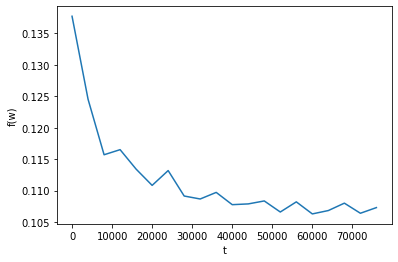

In [20]:
t = np.arange(1,20*feature_vector.shape[0]+1,feature_vector.shape[0])
plt.plot(t,J)
plt.xlabel("t")
plt.ylabel("f(w)")
plt.show()

Adding test data

In [21]:
feature_vector_test = np.zeros((len(new_email_test),len(words_to_number_map)),dtype=int)
for i,j in zip(cxt.row, cxt.col):
    if(j in words_to_number_map.keys()):
        feature_vector_test[i][words_to_number_map[j]]=1
for i in range(0,len(spam_value_test)):
    if(spam_value_test[i]==0):
        spam_value_test[i]=-1

Question 4.2

Assuming that we are using 0-1 loss for this and not the hinge loss

In [29]:
def pegasos_svm_test(data,w):
    y=data[:,-1]
    X = data[:,:-1]
    pred = X@w
    sum=0
    for i in range(pred.shape[0]):
        if(y[i]*pred[i]<0 or y[i]*pred[i]==0 and y[i]==-1):
            sum=sum+1
    return sum/pred.shape[0]
    

In [23]:
def hinge_loss(data,w):
    y=data[:,-1]
    X = data[:,:-1]
    pred = X@w
    sum=0
    for i in range(pred.shape[0]):
        sum=sum+max(0,1-y[i]*pred[i])
    return sum/pred.shape[0]    

In [35]:
y_test = np.array(spam_value_test).reshape(-1,1)
data_test = np.concatenate((feature_vector_test,y_test),axis=1)
error=pegasos_svm_test(data_test,c)
print("Error on the test data is " + str(error))

Error on the test data is 0.031


Question 4.3

In [25]:
y_v = np.array(spam_value_validate).reshape(-1,1)
data_validate = np.concatenate((feature_vector_validate,y_v),axis=1)

Text(0.5, 0, 'log Lambda')

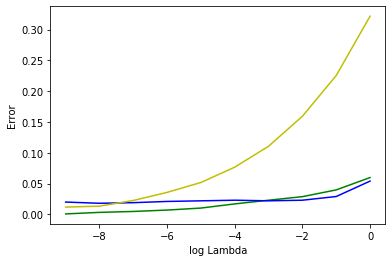

In [31]:
lambdas = 2.**np.arange(-9,1,1)
xaxis=np.arange(-9,1,1)
e=[]
e_validate=[]
e_hinge=[]

for Lambda in lambdas:
    c_train,J = pegasos_svm_train(data,np.zeros(data.shape[1]-1),Lambda=Lambda)
    error = pegasos_svm_test(data,c_train)
    error_val = pegasos_svm_test(data_validate,c_train)
    error_hinge = hinge_loss(data,c_train)
    e.append(error)
    e_validate.append(error_val)
    e_hinge.append(error_hinge)
plt.plot(xaxis,e,color='g')
plt.plot(xaxis,e_validate,color='b')
plt.plot(xaxis,e_hinge,color='y')
plt.ylabel("Error")
plt.xlabel("log Lambda")


Yellow - Hinge loss
Blue - Validation Loss
Green - Training Loss

As we can see Hinge always upper bounds training error

Question 4.4.1

In [32]:
print("Minimum Validation error = " + str(np.min(e_validate)))

Minimum Validation error = 0.018


Question 4.4.2

In [33]:
index = np.argmin(e_validate)
Lambda = lambdas[index]
c,J = pegasos_svm_train(data,np.zeros(data.shape[1]-1),Lambda)
error = pegasos_svm_test(data_test,c)
print("Error on the test set is " + str(error))

Error on the test set is 0.023


Question 4.4.3

Support Vector machines basically try to find the largest margin which means the  perpendicular distance which is closest to either side of the hyper plane
For this we first find $\gamma$ such that
$$
    y_i(b+w_1x_{i1} + w_{i2}x_{i2}) \geq \gamma, \mbox{ for all } i,
$$
Margin is then computed as
$$ 
m = \frac{\gamma}{\|w\|}, \quad \|w\|= \sqrt{ w_1^2 + w_2^2 }.
$$
The points which lie on the margin on either side of the hyperplane are the support vectors


In [87]:
pred = (feature_vector@c).reshape(-1,1)
gammas = y*pred
gammas_correct_positive_label=[]
gammas_correct_negative_label=[]
for i in range(pred.shape[0]):
    if y[i]*pred[i] >1 and y[i]==-1:
        gammas_correct_negative_label.append(y[i]*pred[i])
    elif y[i]*pred[i] >1 and y[i]==1:
        gammas_correct_positive_label.append(y[i]*pred[i])
norm = math.sqrt(c.T@c)
gammas_correct_negative_label = np.array(gammas_correct_negative_label)
gammas_correct_positive_label = np.array(gammas_correct_positive_label)
margin_positive_label = (gammas_correct_positive_label.min())/norm
margin_negative_label = (gammas_correct_negative_label.min())/norm
index1=np.where(gammas/norm==margin_positive_label)
index2=np.where(gammas/norm==margin_negative_label)
print("The emails which are the support vectors are "+ str(index1[0])+"for positive labels and for negative labels is " + str(index2[0]))


The emails which are the support vectors are [2937]for positive labels and for negative labels is [127]


These are the emails which lie closest to our hypothesis plane. There are two points, one at the side of the positive label class and one to the side of negative label class. We found the support vector by finding the minimum distance of the points from the correctly classified points. This was done for both the label classes and then the points were found out

Question 4.4.4

The error coming from the test set by using pegasos comes out to be 0.023 wherease that coming from perceptron came out to be 0.021. We can see that the performance is also same when using the 0-1 loss. However below is an implementation when we removed the filter from the vocabulary. The exercise was done above and is not shown here because of repetition

Sparse vectors were not required because they were used for finding out the final feature vector in the emails

In [19]:
index = np.argmin(e_validate)
Lambda = lambdas[index]
c,J = pegasos_svm_train(data,np.zeros(data.shape[1]-1),Lambda)
error = pegasos_svm_test(data_test,c)
print("Error on the test set is " + str(error))

Error on the test set is 0.019


We can see that the performance of SVM improved and gave a better result than the perceptron algorithm when the features were not filtererd